In [26]:
import pandas as pd
import random as rn
import numpy as np
from netcoloc import netprop_zscore, netprop
import ndex2
import matplotlib.pyplot as plt

In [2]:
DATADIR = "~/Data/rat/data/"

In [4]:
import ndex2
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf'
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_PC = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_PC.nodes)

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:', len(G_PC.nodes))
print('number of edges:', len(G_PC.edges))

number of nodes: 18820
number of edges: 2693250


In [5]:
w_prime = netprop.get_normalized_adjacency_matrix(G_PC, conserve_heat=True, weighted=False)

In [6]:
indiv_heats = netprop.get_individual_heats_matrix(w_prime, alpha=0.5)

In [7]:
data = pd.read_csv(DATADIR+"GIANT_genomics/BMI/GIANT_BMI_pascal.sum.genescores.txt", sep="\t")

## Perform sampling

In [13]:
# -*- coding: utf-8 -*-

"""Functions for getting z-scores from network propagation.
"""

# External library imports

import os
import warnings
from tqdm.auto import tqdm
import ndex2
# Internal module convenience imports
from netcoloc.netcoloc_utils import *
from netcoloc.netprop import *
import random as rn


def netprop_zscore(seed_gene_file, seed_gene_file_delimiter=None, num_reps=10, alpha=0.5, minimum_bin_size=10,
                   interactome_file=None, interactome_uuid='f93f402c-86d4-11e7-a10d-0ac135e8bacf',
                   ndex_server='public.ndexbio.org', ndex_user=None, ndex_password=None, out_name='out',
                   save_z_scores=False, save_final_heat=False, save_random_final_heats=False, verbose=True):
    """
    Performs network heat propagation on the given interactome with the given
    seed genes, then returns the z-scores of the final heat values of each node
    in the interactome.

    The z-scores are calculated based on a null model, which is built by running
    the network propagation multiple times using randomly selected seed genes
    with similar degree distributions to the original seed gene set.

    This method returns a tuple containing the following:

    * :py:class:`pandas.Series` containing z-scores for each gene. Gene names comprise the index column
    * :py:class:`numpy.ndarray` containing square matrix where each row contains the final heat scores
      for each gene from a network propagation from random seed genes

    :param seed_gene_file: Location of file containing a delimited list of
            seed genes
    :type seed_gene_file: str
    :param seed_gene_file_delimiter: Delimiter used to separate genes in seed
                                     gene file. Default any whitespace
    :type seed_gene_file_delimiter: str
    :param num_reps: Number of times the network propagation algorithm should
            be run using random seed genes in order to build the null model
    :type num_reps: int
    :param alpha: Number between 0 and 1. Denotes the importance of the
            propagation step in the network propagation, as opposed to the step
            where heat is added to seed genes only. Recommended to be 0.5 or
            greater
    :type alpha: float
    :param minimum_bin_size: minimum number of genes that should be in
            each degree matching bin.
    :type minimum_bin_size: int
    :param interactome_file: Location of file containing the interactome in
            NetworkX gpickle format. Either the interactome_file argument or the
            interactome_uuid argument must be defined.
    :type interactome_file: str
    :param interactome_uuid: UUID of the interactome on NDEx. Either the
            interactome_file argument or the interactome_uuid argument must be
            defined. (Default: The UUID of PCNet, the Parsimonious Composite
            Network: f93f402c-86d4-11e7-a10d-0ac135e8bacf)
    :type interactome_uuid: str
    :param ndex_server: NDEx server on which the interactome is stored.
            Only needs to be defined if interactome_uuid is defined
    :type ndex_server: str
    :param ndex_user: NDEx user that the interactome belongs to. Only
            needs to be defined if interactome_uuid is defined, and the
            interactome is private
    :type ndex_user: str
    :param ndex_password: password of the NDEx user's account. Only needs
            to be defined if interactome_uuid is defined, and the interactome is
            private
    :type ndex_password: str
    :param out_name: Prefix for saving output files
    :type out_name: str
    :param save_z_scores:
    :param save_final_heat: If ``True``, then the raw network
            propagation heat scores for the original seed gene set will be saved
            in the form of a tsv file in the current directory
    :type save_final_heat: bool
    :param save_random_final_heats: If ``True``, then the raw
            network propagation heat scores for every repetition of the
            algorithm using random seed genes will be saved in the form of a tsv
            file in the current directory. (Beware: This can be a large file if
            num_reps is large.)
    :type save_random_final_heats: bool
    :param verbose: If ``True``, then progress information will
            be logged. Otherwise, nothing will be printed
    :return: (:py:class:`pandas.Series`, :py:class:`numpy.ndarray`)
    :rtype: tuple
    :raises TypeError: If neither interactome_file or interactome_uuid is provided or if
                       **num_reps** is not an ``int``
    """
    # Process arguments

    # seed_gene_file
    seed_gene_file = os.path.abspath(seed_gene_file)
    # num_reps
    try:
        num_reps = int(num_reps)
    except TypeError:
        raise TypeError("The num_reps argument should be an integer")
    # int_file and int_uuid
    if interactome_file is None and interactome_uuid is None:
        raise TypeError("Either interactome_file or interactome_uuid argument must be provided")

    # Load interactome
    if verbose:
        print('Loading interactome')
    if interactome_file is not None:
        interactome_file = os.path.abspath(interactome_file)
        # interactome = nx.Graph()
        interactome = nx.read_gpickle(interactome_file)
    else:
        interactome = ndex2.create_nice_cx_from_server(
            ndex_server,
            username=ndex_user,
            password=ndex_password,
            uuid=interactome_uuid
        ).to_networkx()
    if 'None' in interactome.nodes():
        interactome.remove_node('None')
    nodes = list(interactome.nodes)

    # Log interactome num nodes and edges for diagnostic purposes
    if verbose:
        print('Number of nodes: ' + str(len(interactome.nodes)))
        print('Number of edges: ' + str(len(interactome.edges)))

    # Load seed genes
    seed_file = open(seed_gene_file, 'r')
    seed_genes = list(np.intersect1d(nodes, seed_file.read().split(seed_gene_file_delimiter)))
    if verbose:
        print('\nNumber of seed genes in interactome: ' + str(len(seed_genes)))

    # Calculate individual_heats_matrix from interactome
    if verbose:
        print('\nCalculating w_prime')
    w_prime = get_normalized_adjacency_matrix(interactome, conserve_heat=True)
    if verbose:
        print('\nCalculating individual_heats_matrix')
    individual_heats_matrix = get_individual_heats_matrix(w_prime, alpha)

    # Calculate the z-score
    if verbose:
        print('\nCalculating z-scores: ' + seed_gene_file)
    z_scores, final_heat, random_final_heats = calculate_heat_zscores(
        individual_heats_matrix,
        nodes,
        dict(interactome.degree),
        seed_genes,
        num_reps=num_reps,
        minimum_bin_size=minimum_bin_size)

    # Save z-score results
    z_scores.name = 'z-scores'
    if save_z_scores:
        z_scores.to_csv(out_name + '_z_scores_' + str(num_reps) + '_reps.tsv', sep='\t')

    # If save_final_heat is true, save out the final heat vector
    if save_final_heat:
        final_heat_df = pd.DataFrame(final_heat, columns=['z-scores'])
        final_heat_df.to_csv(out_name + '_final_heat_' + str(num_reps) + '_reps.tsv', sep='\t')

    # If save_random_final_heats is true, save out the vector of randoms (this can be a large file)
    if save_random_final_heats:
        random_final_heats_df = pd.DataFrame(
            random_final_heats.T,
            index=nodes,
            columns=range(1, random_final_heats.shape[0] + 1)
        )
        random_final_heats_df.to_csv(out_name + '_final_heat_random_' + str(num_reps) + '_reps.tsv', sep='\t')

    return z_scores, random_final_heats


def calculate_heat_zscores(individual_heats_matrix, nodes, degrees, seed_genes, num_reps=10,
                           minimum_bin_size=10, random_seed=1):
    """
    Helper function to perform network heat propagation using the given
    individual heats matrix with the given seed genes and return the z-scores of
    the final heat values of each node.

    The z-scores are calculated based on a null model, which is built by running
    the network propagation multiple times using randomly selected seed genes
    with similar degree distributions to the original seed gene set.

    The returned tuple contains the following:

    * :py:class:`pandas.Series` containing z-scores for each gene. Gene names comprise the index column
    * :py:class:`pandas.Series` containing the final heat scores for each gene. Gene names comprise the index column,
    * :py:class:`numpy.ndarray` containing square matrix in which each row contains the final heat scores for each gene
    from a network propagation from random seed genes)

    :param individual_heats_matrix: output of the
            netprop.get_individual_heats_matrix. A square matrix containing the
            final heat contributions of each gene
    :type individual_heats_matrix: :py:class:`numpy.ndarray`
    :param nodes: nodes, in the order in which they were supplied to
            the :py:func:`~netcoloc.netprop.get_normalized_adjacency_matrix` method
            which returns the precursor to the individual_heats_matrix
    :type nodes: list
    :param degrees: Mapping of node names to node degrees
    :type degrees: dict
    :param seed_genes: list of genes to use for network propagation. The
            results of this network propagation will be compared to a set of
            random results in order to obtain z-scores
    :type seed_genes: list
    :param num_reps: Number of times the network propagation algorithm should
            be run using random seed genes in order to build the null model
    :type num_reps: int
    :param minimum_bin_size: minimum number of genes that should be in
            each degree matching bin
    :type minimum_bin_size: int
    :param random_seed:
    :return: (:py:class:`pandas.Series`, :py:class:`pandas.Series`, :py:class:`numpy.ndarray`)
    :rtype: tuple
    """
    # set random seed for reproducibility
    np.random.seed(random_seed)

    # Calculate network propagation results given gene set
    seed_genes = list(np.intersect1d(nodes, seed_genes))
    final_heat = network_propagation(individual_heats_matrix, nodes, seed_genes)

    # Initialize empty matrix for results of random network propagations
    random_final_heats = np.zeros([num_reps, len(final_heat)])

    # Create bins containing genes of similar degree
    bins, actual_degree_to_bin_index = get_degree_binning(degrees, minimum_bin_size)

    # Perform network propagation many times with random seed genes
    for repetition in tqdm(range(num_reps)):
        # Create list of random, degree-matched seed genes
        random_seed_genes = []
        for gene in seed_genes:
            # Find genes with similar degrees to focal gene degree
            degree = degrees[gene]
            genes_of_similar_degree = bins[actual_degree_to_bin_index[degree]]
            # Shuffle the genes in the bin
            np.random.shuffle(genes_of_similar_degree)

            # Add genes to list that haven't already been added
            index = 0
            while genes_of_similar_degree[index] in random_seed_genes:
                index += 1
            random_seed_genes.append(genes_of_similar_degree[index])

        # Perform network propagation with random seed genes
        random_final_heat = network_propagation(individual_heats_matrix, nodes, random_seed_genes)
        # Set seeds to NaN so they don't bias results
        random_final_heat.loc[random_seed_genes] = np.nan
        # Add results to random_final_heats matrix
        random_final_heats[repetition] = random_final_heat

    # Calculate z-scores
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        z_scores = (np.log(final_heat) - np.nanmean(np.log(random_final_heats),
                                                    axis=0)) / np.nanstd(np.log(random_final_heats), axis=0)

    return z_scores, final_heat, random_final_heats


def calculate_heat_zscores_with_sampling(data, nodes, individual_heats, G_PC, trait="BMI", max_genes=500,
                                         num_samples=100,
                                         nominal_sig=0.05, num_reps=1000, out_path="", minimum_bin_size=10):
    """
    Takes a set of summary statistics and a molecular interaction and performs sampling of the significant genes.
    For each sample a random selection of seed genes is chosen, weighted by the p-value of each gene in the summary
    statistics. Network propagation with zscore calculation is performed for each sample to generate a distribution
    of z-scores for each gene in the seed_gene set.
    :param data: Gene level summary statistics
    :param nodes: list of nodes in the interaction network
    :param individual_heats: Heat matrix calculated by `netprop_zscore.get_individual_heats_matrix())
    :param G_PC: molecular interaction network
    :param trait: name of trait being investigated
    :param max_genes: Maximum number of seed genes to include in each sample (default=500, maximum=500)
    :param num_samples: Number of times to perform sampling (default=100)
    :param nominal_sig: Significance cutoff for keeping genes in data (Note: this value will be Bonferroni corrected)
    :param num_reps: Number of repetitions of randomization for generating null distribution for z_scores
    :param out_path: prefix for saving results of sampling
    :param minimum_bin_size: minimum number of genes that should be in
            each degree matching bin
    :type minimum_bin_size: int
    :return:
    """
    assert max_genes <= 500, "NetColoc is only valid for sets of 500 or less genes so maximum number of genes for " \
                             "sampling must be <= 500"
    outfile = out_path + trait + "sampling_" + str(max_genes) + "_" + str(num_samples) + ".tsv"
    data = data.loc[data.gene_symbol.isin(nodes)]  # subset to genes in interaction network
    all_seeds = data.loc[data.pvalue <= nominal_sig / len(data)]  # Bonferroni correction
    all_seeds = all_seeds.assign(log10p=-1 * np.log10(all_seeds.pvalue))  # get -log10p for weighted sampling
    sampling_results = []
    for i in range(num_samples):
        # perform propagation for sample
        sample_seeds = rn.choices(population=all_seeds.gene_symbol.values, weights=all_seeds.log10p.values, k=max_genes)
        sample_results = calculate_heat_zscores(individual_heats, nodes=list(G_PC.nodes), degrees=dict(G_PC.degree),
                                                seed_genes=sample_seeds, num_reps=num_reps,
                                                minimum_bin_size=minimum_bin_size, random_seed=i)[0]
        sample_z = pd.DataFrame(sample_results, columns=["z" + str(i)])
        # save running results of sampling
        if i == 0:
            sample_z.to_csv(outfile, sep="\t")
        else:
            existing = pd.read_csv(outfile, sep="\t", index_col=0)
            existing = existing.join(sample_z)
            existing.to_csv(outfile, sep="\t")
        sampling_results.append(sample_z)

    return pd.concat(sampling_results, axis=1)


def get_consensus_z_scores(sampled_results, percentile=.75):
    """
    returns the consensus z score for each gene across all samples
    :param sampled_results: output of netprop_zscore.calculate_heat_zscores_with_sampling
    :type sampled_results: str (file path) or pandas.DataFrame
    :param percentile: Percentile cut off for determining consensus score (default=0.75)
    :type percentile: float
    :return: Consensus z-scores for all genes based on sampling
    """
    if type(sampled_results) == str:
        results = pd.read_csv(sampled_results, sep="\t", index_col=0)
    else:
        results = sampled_results
    consensus_z = pd.DataFrame({'z': results.quantile(q=percentile, axis=1)})
    return consensus_z


In [33]:
sampled_data = calculate_heat_zscores_with_sampling(data, nodes, indiv_heats, G_PC, trait="BMI", num_samples=100, 
                                                                  num_reps=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
sampled_consensus = get_consensus_z_scores(sampled_data, percentile=0.75)

## Compare to previous results

In [35]:
original_results = get_consensus_z_scores(DATADIR+'final/z_human_bin_BMI_SAMPLED_500_100_weighted.tsv')

In [36]:
all_results = original_results.join(sampled_consensus, rsuffix="_new", lsuffix="_original")

Text(0, 0.5, 'New Scores')

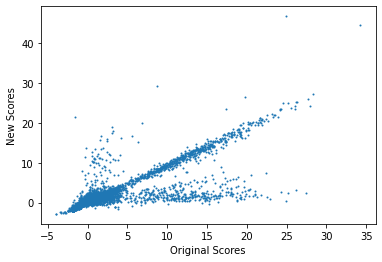

In [43]:
plt.scatter(data=all_results, x = "z_original", y="z_new", s=1)
plt.xlabel("Original Scores")
plt.ylabel("New Scores")

In [38]:
sample_a = get_consensus_z_scores("~/Git/rat_genetics/BMIsampling_500_100_a.tsv")

In [39]:
sample_combo = sample_a.join(sampled_consensus, rsuffix='b', lsuffix='a')

In [41]:
sample_combo.head()

,za,zb
UBE2Q1,-0.186779,-0.035184
RNF14,-0.477954,-0.410932
UBE2Q2,0.102486,0.226293
TMCO1,-0.531951,-0.312104
UBAC1,1.591813,1.919019


Text(0, 0.5, 'sample_b')

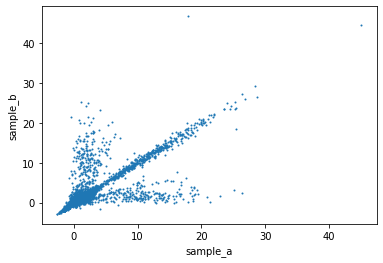

In [53]:
plt.scatter(data=sample_combo, x="za",y="zb", s=1)
plt.xlabel("sample_a")
plt.ylabel("sample_b")

In [48]:
from scipy.stats import pearsonr, spearmanr


In [51]:
spearmanr(sample_combo.za, sample_combo.zb)

SpearmanrResult(correlation=0.9485776306387278, pvalue=0.0)

In [52]:
spearmanr(all_results.z_original, all_results.z_new)

SpearmanrResult(correlation=0.9126193769465397, pvalue=0.0)

# OLD ---------------------------------------------

In [46]:
def sampling_from_pascal(pascal_file_list, trait_list, outpath, num_samps=100, num_reps=1000):
    # import PCNET
    print("Loading PCNet")
    interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf'
    ndex_server='public.ndexbio.org'
    ndex_user=None
    ndex_password=None
    G_PC = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
    nodes = list(G_PC.nodes)
    # calculate heat matrix
    print("Calculating w_prime")
    w_prime = netprop.get_normalized_adjacency_matrix(G_PC, conserve_heat=True, weighted=False)
    print("Calculating heat matrix")
    indiv_heats = netprop.get_individual_heats_matrix(w_prime, alpha=0.5)
    # perform each sampling analysis
    consensus_z_scores = {}
    for i, file in enumerate(pascal_file_list):
        data = pd.read_csv(file, sep="\t")
        trait = trait_list[i]
        print("Sampling", trait)
        res = sample_seed_genes(data, nodes, indiv_heats, G_PC, trait=trait, max_genes=500, num_samps=num_samps,
                             outdir=outpath, num_reps=num_reps)
        print("Finished sampling", trait)
        consensus_z_scores[trait] = get_consensus_z_scores(res)
    return consensus_z_scores
        
def sample_seed_genes(data, nodes, indiv_heats, G_PC, trait="BMI", max_genes=500, num_samps=100, 
                      sig=0.05, num_reps=1000, parallel=False, outdir=DATADIR):
    outfile=outdir+trait+"sampling_"+str(max_genes)+"_"+str(num_samps)+".tsv"
    data = data.loc[data.gene_symbol.isin(nodes)] # subset to genes in PCNET
    all_seeds = data.loc[data.pvalue <= sig/len(data)] # bonferonni correction
    all_seeds = all_seeds.assign(log10p=-1*np.log10(all_seeds.pvalue)) # get -log10p for weighted sampling
    sampling_results = []
    if parallel:
        pool = mp.Pool(2)
        #sampling_results = [pool.apply(_do_propagation, args=(all_seeds, G_PC, indiv_heats, num_reps, max_genes)) for i in range(3)]
        pool.close()
    else:
        for i in range(num_samps):
            sample_results = _do_propagation(all_seeds, G_PC, indiv_heats, num_reps, max_genes)
            sample_z = pd.DataFrame(sample_results, columns=["z"+str(i)])
            if i ==0 :
                sample_z.to_csv(outfile, sep="\t")
            else:
                existing = pd.read_csv(outfile, sep="\t", index_col=0)
                existing = existing.join(sample_z)
                existing.to_csv(outfile, sep="\t")
            sampling_results.append(sample_z)
    
    return pd.concat(sampling_results, axis=1)


def _do_propagation(all_seeds, G_PC, indiv_heats, num_reps=1000, max_genes=500):
    sample_seeds = rn.choices(population=all_seeds.gene_symbol.values, weights=all_seeds.log10p.values, k=max_genes)
    samp_results = netprop_zscore.calculate_heat_zscores(indiv_heats, nodes=list(G_PC.nodes), degrees=dict(G_PC.degree),
                                                         seed_genes=sample_seeds,num_reps=num_reps, alpha=0.05, 
                                                         minimum_bin_size=10, random_seed=1)
    return samp_results[0]


def get_consensus_z_scores(sampled_results, percentile=.75):
    """
    returns the consensus z score for each gene across all samples
    """
    if type(sampled_results) == str:
        results = pd.read_csv(sampled_results, sep="\t", index_col=0)
    else:
        results = sampled_results
    consensus_z = pd.DataFrame({'z':results.quantile(q=percentile, axis=1)})
    return consensus_z

### Option 1 - run a list of pascal files

In [47]:
file_list=[DATADIR+"GIANT_genomics/BMI/GIANT_BMI_pascal.sum.genescores.txt"] # list of tab-separated pascal files
trait_list=["BMI"] # trait names for naming output files
outpath="" # location to save results
sampling_from_pascal(file_list, trait_list, outpath, num_samps=4, num_reps=10)

Loading PCNet
Calculating w_prime
Calculating heat matrix
Sampling BMI


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Finished sampling BMI


{'BMI':                 z
 UBE2Q1  -0.050077
 RNF14    0.065487
 UBE2Q2   2.744207
 TMCO1    0.133241
 UBAC1    0.375765
 ...           ...
 CD300LD  1.243231
 SLC10A5  0.226971
 BAGE4   -0.482724
 FAM181B  1.738547
 TPT1P8   0.507057
 
 [18820 rows x 1 columns]}

### Option 2 - run one trait at a time, but precalculate pcnet heat matrix

In [21]:
a = sample_seed_genes(data, nodes, indiv_heats, G_PC, num_reps=10, num_samps=4, trait="BMI")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
get_consensus_z_scores(a)

,z
UBE2Q1,0.046308
RNF14,-1.284102
UBE2Q2,0.304512
TMCO1,-0.603054
UBAC1,0.536572
...,...
CD300LD,1.944859
SLC10A5,10.460008
BAGE4,2.367835
FAM181B,1.499096
